# Shuffling norm judgments
***
Does the value of a norm have impact on the classification accuracy? We test this hypothesis by applying the `Learn2Split` model and shuffling of the value judgments. In the end, we train the action classification task and compare.

Shuffle strategies:
* Truly randomn
    * Will cause most errornous sentences of the strategies
* Mirroring polarity: Choose the closest opposite value.
* Single polarity: All values are the same
    * This effectively reduces the task to NLI! Here we HAVE to be better!
    
    
### Approach
***
The `L2S` model not only splits a norm, but also conjugates the action:
* `It's wrong to become addicted to gambling.` becomes
    * `It's wrong`
    * `becoming addicted to gambling`

Since the splitting is not reversible as is, there are two possible options to consider:
1. Re-run the original model on concatenated `L2S` output. If the accuracy does not drop, then we can simply do our comparison experiments on `L2S` concat'ed. 
2. Train a `L2S` reverse model (*sigh*)

##### ...and then:
1. Prepare the datasets
    1. `moral_stories_random_value`
    2. `moral_stories_mirrored_value`
    3. `moral_stories_single_value`
2. Train the action classification task

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

pd.set_option('display.max_colwidth', 400)
dataframe = pd.read_pickle("../data/moral_stories_proto_l2s.dat")

### Action classification on `L2S` concatenated
***
Question: If we concatenate the norm judgment with the conjugated norm action, does the accuracy change?

The task was run for 5 epochs on the `roberta-large` model:
* Epoch 5: 0.913 accuracy

Although not a thorough analysis in any capacity, we argue that the performance is not significantly reduced by the simplistic concatenation approach. The upcoming experiments on the shuffled datasets can be carried out without greater worries!

In [3]:
from sklearn.model_selection import train_test_split
from ailignment.datasets.moral_stories import make_action_classification_dataframe

data = dataframe.copy()
data["norm"] = data["norm_value"] + " " + data["norm_action"]
data = make_action_classification_dataframe(data)
train, test = train_test_split(data, test_size=0.1)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

name = "roberta-large"
#name = "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)

In [ ]:
# split into val data
# convert the dataframe to a huggingface dataset and tokenize the sentences
from datasets import Dataset

def tok(samples):
    return tokenizer(samples["action"], samples["norm"], padding="max_length", 
                     truncation=True, return_token_type_ids=True)

train_data = Dataset.from_pandas(train)
train_data = train_data.map(tok, batched=True)
val_data = Dataset.from_pandas(test)
val_data = val_data.map(tok, batched=True)

  0%|          | 0/22 [00:00<?, ?ba/s]

In [ ]:
from transformers import Trainer, TrainingArguments
import torch
from ailignment.datasets.util import get_accuracy_metric

training_args = TrainingArguments(
    output_dir="/data/kiehne/results/shuffled_values/verification/",
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='logs/',
    log_level="info",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_steps=30000000,
    save_strategy="epoch",
    learning_rate=1e-5
    
)
acc_metric = get_accuracy_metric()

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=acc_metric,
)
logs = trainer.train()

## Dataset creation
***
Below we prepare the three variants to check against:
1. `moral_stories_random_value`
2. `moral_stories_mirrored_value`
3. `moral_stories_single_value`

Columns affected by changing value judgments:
* `norm`, `norm_sentiment`, `norm_value`

In [2]:
def simplify_norm_value(row):
    '''
    Casts each norm judgment into "It is bad" or "It is good" based on
    the sentiment.
    '''
    x = row.copy()
    x["norm_value"] = "It is bad" if x["norm_sentiment"] == "NEGATIVE" else "It is good"
    return x

def flip_norm(p=0.5):
    '''
    Returns a function that flips the given norm with probability p.
    Flipping means changing the value judgment to the opposite sentiment.
    Specifically:
    - norm_sentiment: A negative sentiment becomes good, e.g. "It is bad" will be "It is good"
    - The moral and immoral actions will be swapped to account for the flip
    - Same for the respective consequences
    
    In both cases (flip and non flip), the norm field will be re-initialised
    to the concatenation of norm_value and norm_action.
    The norm field will be changed to the 
    '''
    def flip(row):
        x = row.copy()
        x["flipped"] = False
        if np.random.rand()<=p:
            x["norm_value"] = "It is bad" if x["norm_sentiment"] == "POSITIVE" else "It is good"
            x["norm_sentiment"] = "POSITIVE" if x["norm_sentiment"] == "NEGATIVE" else "NEGATIVE"

            x["moral_action"] = row["immoral_action"]
            x["moral_consequence"] = row["immoral_consequence"]
            x["immoral_action"] = row["moral_action"]
            x["immoral_consequence"] = row["moral_consequence"]
            x["flipped"] = True
        
        x["norm"] = x["norm_value"] + " " + x["norm_action"]
        return x
    return flip

#### Random value dataset
***
1. Enforcing a uniform value distribution.

**Problem**: There are value judgments that are tailored to a specific situation, e.g. "It is homophobic" or "It is lazy". Randonmly reassigning these doesn't seem right...

**Solution**: For the lack of better ideas, any norm with a positive sentiment gets "It is good" and the negative case "It is bad". Next, we decide for each norm randomly, whether its sentiment gets flipped.


#### Results:
* $p=0 \rightarrow 0.916$
* $p=1 \rightarrow 0.915$
* $p=\frac{1}{4} \rightarrow 0.875$
* $p=0.45 \rightarrow 0.5$
* $p=0.5 \rightarrow 0.5$

In [3]:
p = 0.5
random_values = dataframe.copy()
random_values = random_values.apply(simplify_norm_value, axis=1).apply(flip_norm(p), axis=1)
random_values.to_pickle(f"../data/moral_stories_random_values.dat")

### Mirrored value dataset
***
Choose the opposite judgment for the norm:
* What was good is now bad and vice versa.
* Moral actions are now immoral and vice versa.

**Note**: As a first step, we first simplify judgments to good/bad!

Results:
* First run with `roberta-large`: $0.905$ accuracy, so pretty much no difference to original dataset

In [37]:
mirrored = dataframe.copy()
mirrored["norm_value"] = mirrored["norm_sentiment"].apply(lambda x: "It is bad" if x == "POSITIVE" else "It is good")
mirrored["norm_sentiment"] = mirrored["norm_sentiment"].apply(lambda x: "POSITIVE" if x == "NEGATIVE" else "NEGATIVE")
mirrored = mirrored.rename({"immoral_action":"moral_action","moral_action":"immoral_action",
                            "immoral_consequence":"moral_consequence","moral_consequence":"immoral_consequence"}, axis=1)
mirrored["norm"] = mirrored["norm_value"] + " " + mirrored["norm_action"]
mirrored.to_pickle("../data/moral_stories_mirrored_values.dat")

# Experiments: Single model training
***
Pick a dataset, then run the finetuning. Useful for explorative analysis

In [2]:
from sklearn.model_selection import train_test_split
from ailignment.datasets.moral_stories import make_action_classification_dataframe
import pandas as pd
import numpy as np

dataframe = pd.read_pickle("../data/moral_stories_random_values.dat")

data = dataframe.copy()
train, test = make_action_classification_dataframe(data)


ValueError: too many values to unpack (expected 2)

In [8]:
    immoral_df = dataframe.drop(["moral_action", "moral_consequence"], axis=1)
    moral_df = dataframe.drop(["immoral_action", "immoral_consequence"], axis=1)
    # rename columns
    moral_df.rename(columns={"moral_action":"action",
                            "moral_consequence":"consequence"},
                    inplace=True)
    immoral_df.rename(columns={"immoral_action":"action",
                            "immoral_consequence":"consequence"},
                    inplace=True)
    # add labels
    immoral_df["labels"] = 0
    moral_df["labels"] = 1

In [21]:
im = train_test_split([immoral_df, moral_df], test_size=0.1)

In [37]:
np.random.randint(1)

0

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

name = "roberta-large"
#name = "bert-base-uncased"
#name = "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

In [3]:
from datasets import Dataset

def tok(samples):
    return tokenizer(samples["action"], samples["norm"], padding="max_length", 
                     truncation=True, return_token_type_ids=True)

train_data = Dataset.from_pandas(train)
train_data = train_data.map(tok, batched=True)
val_data = Dataset.from_pandas(test)
val_data = val_data.map(tok, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [4]:
from transformers import Trainer, TrainingArguments
import torch
from ailignment.datasets.util import get_accuracy_metric

training_args = TrainingArguments(
    output_dir="/data/kiehne/results/shuffled_values/random/single_runs/",
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    #weight_decay=0.01,
    logging_dir='logs/',
    log_level="info",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_steps=30000000,
    save_strategy="epoch",
    learning_rate=1e-5
    
)
acc_metric = get_accuracy_metric()

In [5]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=acc_metric,
)
logs = trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, actor_name, flipped, ID, norm_action, intention, norm_value, l2s_output, norm_storyfied, norm_sentiment, situation, action, consequence, norm.
***** Running training *****
  Num examples = 4500
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2810
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
0,0.706200,0.693038,0.512000
1,0.700500,0.693387,0.494000


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, actor_name, flipped, ID, norm_action, intention, norm_value, l2s_output, norm_storyfied, norm_sentiment, situation, action, consequence, norm.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/single_runs/checkpoint-562
Configuration saved in /data/kiehne/results/shuffled_values/random/single_runs/checkpoint-562/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/single_runs/checkpoint-562/pytorch_model.bin
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but al

KeyboardInterrupt: 

# Experiments: Consecutive models
***
Run several models over different training data or with different hyperparameters.

### Random values experiment
***
Given different values of $p$, how is the accuracy affected? 

First run:
* Single epoch, batch size 8, $p\in\{0,0.1,0.2,..,1\}$

In [2]:
from ailignment.training import sequence_classification
from ailignment.datasets.moral_stories import make_action_classification_dataframe
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
from ailignment.datasets.util import get_accuracy_metric
from datasets import Dataset
import numpy as np
import pandas as pd

import transformers
transformers.logging.set_verbosity_warning()

ps = np.linspace(0,1,11)
test_size = 0.1
seed = 3
model = "roberta-large"

acc_metric = get_accuracy_metric()
results = []

for p in ps:
    # create dataset
    dataframe = pd.read_pickle("../data/moral_stories_proto_l2s.dat")
    random_values = dataframe.apply(simplify_norm_value, axis=1).apply(flip_norm(p), axis=1)
    data = make_action_classification_dataframe(random_values)
    train, test = train_test_split(data, test_size=test_size, random_state=seed)

    # create training args
    training_args = TrainingArguments(
        output_dir=f"/data/kiehne/results/shuffled_values/random/{p:0.2f}/",
        num_train_epochs=1,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='logs/',
        log_level="info",
        logging_steps=500,
        evaluation_strategy="epoch",
        save_steps=30000000,
        save_strategy="epoch",
        learning_rate=1e-5   
    )
    
    # create data loading function
    def data_func(tokenizer):
        def tok(samples):
            return tokenizer(samples["action"], samples["norm"], padding="max_length", 
                             truncation=True, return_token_type_ids=True)

        train_data = Dataset.from_pandas(train)
        train_data = train_data.map(tok, batched=True)
        val_data = Dataset.from_pandas(test)
        val_data = val_data.map(tok, batched=True)
        return train_data, val_data
    
    r = sequence_classification(data_func, model, training_args, acc_metric)
    results.append(r)

accuracies = [[y for y in x if "eval_accuracy" in y][0]["eval_accuracy"] for x in results]


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.386900,0.366239,0.908750


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.00/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.00/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.00/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.357000,0.357077,0.898750


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.10/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.10/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.10/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.696500,0.692857,0.512083


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.20/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.20/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.20/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.515500,0.440866,0.820833


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.30/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.30/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.30/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.696600,0.692861,0.512083


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.40/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.40/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.40/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697000,0.692859,0.512083


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.50/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.50/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.50/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.680000,0.655768,0.663750


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.60/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.60/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.60/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.541600,0.465840,0.796667


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.70/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.70/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.70/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.398800,0.319683,0.882917


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.80/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.80/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.80/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.380000,0.382039,0.893333


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/0.90/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/0.90/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/0.90/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You shou

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running training *****
  Num examples = 21592
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 2699
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.388900,0.320940,0.911250


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: consequence, norm_storyfied, norm_sentiment, norm_action, flipped, action, __index_level_0__, actor_name, norm, intention, norm_value, situation, ID, l2s_output.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
Saving model checkpoint to /data/kiehne/results/shuffled_values/random/1.00/checkpoint-2699
Configuration saved in /data/kiehne/results/shuffled_values/random/1.00/checkpoint-2699/config.json
Model weights saved in /data/kiehne/results/shuffled_values/random/1.00/checkpoint-2699/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




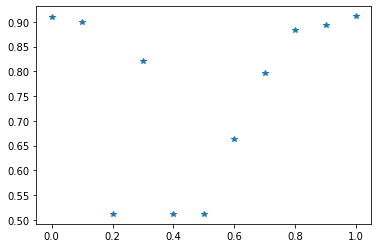

In [8]:
import matplotlib.pyplot as plt

plt.plot(ps, accuracies, "*")
plt.show()

In [ ]:
from ailignment.training import sequence_classification
from ailignment.datasets.moral_stories import make_action_classification_dataframe
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
from ailignment.datasets.util import get_accuracy_metric
from datasets import Dataset
import numpy as np
import pandas as pd

import transformers
transformers.logging.set_verbosity_warning()

test_size = 0.1
seed = 3
model = "roberta-large"

acc_metric = get_accuracy_metric()
results = []

dataframe = pd.read_pickle("../data/moral_stories_proto_l2s.dat")
random_values = dataframe.apply(simplify_norm_value, axis=1).apply(flip_norm(0.5), axis=1)
data = make_action_classification_dataframe(random_values)
train, test = train_test_split(data, test_size=test_size, random_state=seed)

# create data loading function
def data_func(tokenizer):
    def tok(samples):
        return tokenizer(samples["action"], samples["norm"], padding="max_length", 
                         truncation=True, return_token_type_ids=True)

    train_data = Dataset.from_pandas(train)
    train_data = train_data.map(tok, batched=True)
    val_data = Dataset.from_pandas(test)
    val_data = val_data.map(tok, batched=True)
    return train_data, val_data

for lr in [1e-5, 1e-6, 1e-7, 1e-8]:
    # create training args
    training_args = TrainingArguments(
        output_dir=f"/data/kiehne/results/shuffled_values/random/{lr:0.2f}/",
        num_train_epochs=2,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='logs/',
        log_level="info",
        logging_steps=500,
        evaluation_strategy="epoch",
        save_steps=3000000000,
        save_strategy="steps",
        learning_rate=lr,
    )
    
    r = sequence_classification(data_func, model, training_args, acc_metric)
    results.append(r)

accuracies = [[y for y in x if "eval_accuracy" in y][0]["eval_accuracy"] for x in results]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'clas

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 5398
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.698300,0.692919,0.512083
2,0.694600,0.693431,0.487917


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 5398
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.699200,0.693389,0.492083
2,0.697000,0.694151,0.487083


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 5398
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.707300,0.693109,0.500833
2,0.705400,0.694262,0.507083


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 2
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: norm, l2s_output, norm_sentiment, actor_name, norm_storyfied, flipped, intention, ID, action, norm_value, situation, consequence, __index_level_0__, norm_action.
***** Running training *****
  Num examples = 21592
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 5398
/home/kiehne/workspace/jupyter-notebooks/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


In [7]:
accuracies = [[y for y in x if "eval_accuracy" in y][0]["eval_accuracy"] for x in results]
accuracies

[0.5120833333333333,
 0.4920833333333333,
 0.5008333333333334,
 0.5120833333333333]

# Post training evaluation
***
Whenever your local machine loses connection to a running notebook it will not receive the console outputs anymore, even though it might be connected to the kernel.
This is a known issue in jupyter, which will not be addressed anytime soon.

In [26]:
import os
from ailignment.training.finetune import clean_up_mem

@clean_up_mem
def evaluate(path):
    '''
    Loads the model in `path` and runs test evaluation on it
    '''
    model = AutoModelForSequenceClassification.from_pretrained(path)
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=acc_metric,
    )
    logs = trainer.evaluate(val_data)
    return logs

def evaluate_folder(folder):
    '''
    Runs `evaluate` on all checkpoints in the given folder.
    Returns a dict {"checkpoint-X": log_dict, .. }
    '''
    ckpts = os.listdir(folder)
    results = {ckpt:evaluate(os.path.join(folder, ckpt)) for ckpt in ckpts}
    return results